In [17]:
from transformers import AutoTokenizer
from benchmark_workload_gen import ToolBenchDataLoader, LoadDistribution
import random
from dataclasses import dataclass
import re


num_workloads = 100
num_requests = 4096
tokenizer = AutoTokenizer.from_pretrained("mistralai/Mistral-7B-v0.1")
dataloader = ToolBenchDataLoader(
    "G1_workload_updated_input_output_lengths_4096_cropped_to_50.json",
    num_workloads,
    num_requests,
    tokenizer,
    LoadDistribution.ALL,
)

In [2]:
import json
from tqdm import tqdm


def add_tokenizer_lengths_to_input_output():
    data_dic = {}
    num_items_skipped = 0
    batch_size = 32  # Adjust batch size as needed

    # Group items into batches and encode prompts in each batch
    for k, items in tqdm(
        dataloader.data.items(), desc="Adding tokenizer lengths to input"
    ):
        batched_items = [
            items[i : i + batch_size] for i in range(0, len(items), batch_size)
        ]
        for batch in batched_items:
            encoded_prompts = [tokenizer.encode(item["prompt"]) for item in batch]
            for item, encoded_prompt in zip(batch, encoded_prompts):
                item["tokenizer_len"] = len(encoded_prompt)
                data_dic.setdefault(k, []).append(item)

    print("Finished adding tokenizer lengths to input")
    data_dic_with_input_output_lens = {}
    for k, items in tqdm(data_dic.items(), desc="Adding output tokenizer lengths"):
        batched_items = [
            items[i : i + batch_size] for i in range(0, len(items), batch_size)
        ]
        for batch in batched_items:
            encoded_prompts = [tokenizer.encode(item["output"]) for item in batch]
            for item, encoded_prompt in zip(batch, encoded_prompts):
                item["output_tokenizer_len"] = len(encoded_prompt)
                data_dic_with_input_output_lens.setdefault(k, []).append(item)
    with open("G1_workload_updated_with_input_output.json", "w") as f:
        json.dump(data_dic_with_input_output_lens, f)
    return data_dic_with_input_output_lens


# output = add_tokenizer_lengths_to_input_output()

In [3]:
total_sum = 0
total_1024 = 0
total_2048 = 0
total_4096 = 0

filter_1024_data = {}
filter_2048_data = {}
filter_4096_data = {}
max_len = 0
for k, items in dataloader.data.items():
    for item in items:
        total_sum += 1
        if item["tokenizer_len"] <= 1024:
            filter_1024_data.setdefault(k, []).append(item)
            total_1024 += 1

        if item["tokenizer_len"] <= 2048:
            filter_2048_data.setdefault(k, []).append(item)
            total_2048 += 1

        if item["tokenizer_len"] <= 4096:
            filter_4096_data.setdefault(k, []).append(item)
            total_4096 += 1
        max_len = max(max_len, item["tokenizer_len"])

rest_sum = total_sum - total_4096
print(
    f"% less than 1024 {total_1024 / total_sum}, % less than 2048 {total_2048 / total_sum}, % less than 4096 {total_4096/total_sum}   Rest: {(rest_sum) / total_sum}, Max Len: {max_len}"
)

% less than 1024 0.10662737922676616, % less than 2048 0.6736354347361168, % less than 4096 1.0   Rest: 0.0, Max Len: 4096


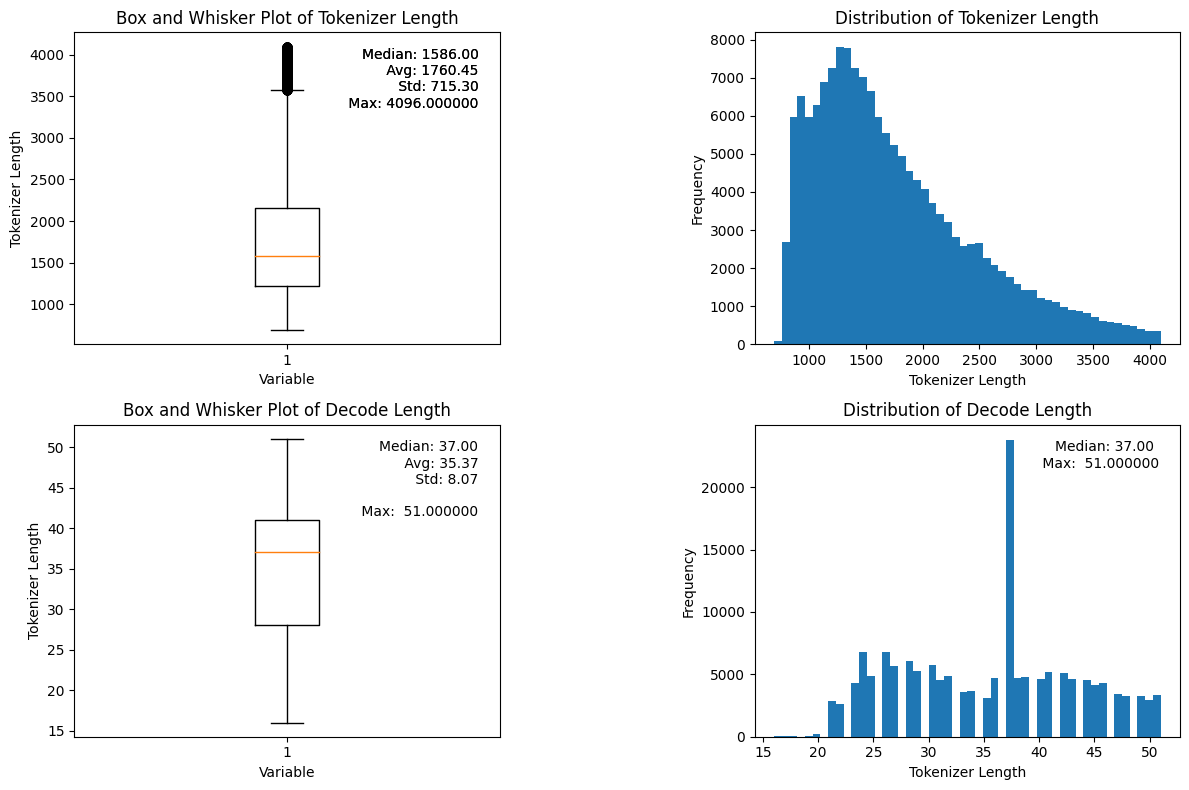

In [18]:
import matplotlib.pyplot as plt
import numpy as np

# Get the tokenizer lengths from the dataset
tokenizer_lengths = [
    item["tokenizer_len"] for items in dataloader.data.values() for item in items
]
decoder_lengths = [
    item["output_tokenizer_len"] for items in dataloader.data.values() for item in items
]
# Define a threshold for outliers (e.g., 1.5 times the interquartile range)
# IQR = np.percentile(decoder_lengths, 75) - np.percentile(decoder_lengths, 25)
# threshold = 1.5 * IQR
# median_decode =  np.median(decoder_lengths)
# filtered_lengths = [length for length in decoder_lengths if abs(length - median_decode) <= threshold]
# print(np.percentile(decoder_lengths, 75))

# # Define a threshold for outliers (e.g., 1.5 times the interquartile range)
# IQR = np.percentile(tokenizer_lengths, 75) - np.percentile(tokenizer_lengths, 25)
# threshold = 1.5 * IQR
# median_tokn_len =  np.median(tokenizer_lengths)
# tokenizer_lengths = [length for length in tokenizer_lengths if abs(length - median_tokn_len) <= threshold]

fig, axs = plt.subplots(2, 2, figsize=(12, 8))

# Box plot of tokenizer lengths
axs[0, 0].boxplot(tokenizer_lengths)
axs[0, 0].set_xlabel("Variable")
axs[0, 0].set_ylabel("Tokenizer Length")
axs[0, 0].set_title("Box and Whisker Plot of Tokenizer Length")
axs[0, 0].text(
    0.95,
    0.95,
    f"Median: {np.median(tokenizer_lengths):.2f}\n Avg: {np.mean(tokenizer_lengths):.2f}\n Std: {np.std(tokenizer_lengths):.2f}\n Max: {np.max(tokenizer_lengths):2f}",
    horizontalalignment="right",
    verticalalignment="top",
    transform=axs[0, 0].transAxes,
)

# Histogram of tokenizer lengths
axs[0, 1].hist(tokenizer_lengths, bins=50)
axs[0, 1].set_xlabel("Tokenizer Length")
axs[0, 1].set_ylabel("Frequency")
axs[0, 1].set_title("Distribution of Tokenizer Length")
axs[0, 1].text(
    0.95,
    0.95,
    f"Median: {np.median(tokenizer_lengths):.2f}\n Avg: {np.mean(tokenizer_lengths):.2f}\n Std: {np.std(tokenizer_lengths):.2f}\n Max: {np.max(tokenizer_lengths):2f}",
    horizontalalignment="right",
    verticalalignment="top",
    transform=axs[0, 0].transAxes,
)

# Box plot of decoder lengths
axs[1, 0].boxplot(decoder_lengths)
axs[1, 0].set_xlabel("Variable")
axs[1, 0].set_ylabel("Tokenizer Length")
axs[1, 0].set_title("Box and Whisker Plot of Decode Length")
axs[1, 0].text(
    0.95,
    0.95,
    f"Median: {np.median(decoder_lengths):.2f}\n Avg: {np.mean(decoder_lengths):.2f}\n Std: {np.std(decoder_lengths):.2f}\n  \n Max: {np.max(decoder_lengths): 2f}",
    horizontalalignment="right",
    verticalalignment="top",
    transform=axs[1, 0].transAxes,
)

# Histogram of decoder lengths
axs[1, 1].hist(decoder_lengths, bins=50)
axs[1, 1].set_xlabel("Tokenizer Length")
axs[1, 1].set_ylabel("Frequency")
axs[1, 1].set_title("Distribution of Decode Length")
axs[1, 1].text(
    0.95,
    0.95,
    f"Median: {np.median(decoder_lengths):.2f} \n Max: {np.max(decoder_lengths): 2f}",
    horizontalalignment="right",
    verticalalignment="top",
    transform=axs[1, 1].transAxes,
)

plt.tight_layout()
plt.show()

In [7]:
import json

total_sum = 0
total_1024 = 0
total_2048 = 0
total_4096 = 0

filter_1024_data = {}
filter_2048_data = {}
filter_4096_data = {}
max_len = 0
# max_deocde = 94
max_deocde = 51  # 75 percentile of data
for k, items in dataloader.data.items():
    for item in items:
        total_sum += 1
        if item["tokenizer_len"] <= 1024:
            if item["output_tokenizer_len"] <= max_deocde:
                filter_1024_data.setdefault(k, []).append(item)
                total_1024 += 1

        if item["tokenizer_len"] <= 2048:
            if item["output_tokenizer_len"] <= max_deocde:
                filter_2048_data.setdefault(k, []).append(item)
                total_2048 += 1

        if item["tokenizer_len"] <= 4096:
            if item["output_tokenizer_len"] <= max_deocde:
                filter_4096_data.setdefault(k, []).append(item)
                total_4096 += 1
        max_len = max(max_len, item["tokenizer_len"])

rest_sum = total_sum - total_4096
print(
    f"% less than 1024 {total_1024 / total_sum}, % less than 2048 {total_2048 / total_sum}, % less than 4096 {total_4096/total_sum}   Rest: {(rest_sum) / total_sum}, Max Len: {max_len}"
)
print(
    f"1024: {total_1024}, 2048: {total_2048}, 4096: {total_4096}, Rest: {rest_sum} Total Sum: {total_sum}"
)
# save 1024 workload to disk
with open("G1_workload_updated_input_output_lengths_4096_cropped_to_50.json", "w") as f:
    json.dump(filter_4096_data, f)
# 0.9486537519043512 % of the data occurs within 4096

% less than 1024 0.09685146020958582, % less than 2048 0.5346386902074471, % less than 4096 0.7506499061378704   Rest: 0.2493500938621296, Max Len: 4096
1024: 20379, 2048: 112496, 4096: 157948, Rest: 52467 Total Sum: 210415


0.5


50 50


{'world_time': 0,
 'reqres_dont_change': 1,
 'endpoint_monitor_tool': 0,
 'swagger_petstore': 1,
 'realtor': 0,
 'k_pop': 1,
 'freedom_finance': 0,
 'ai_writer': 1,
 'opensea_data_query': 0,
 'sandbox_mktplace_eu_04_orders': 1,
 'global_recession_live': 0,
 'cat_facts': 1,
 'luhn_algorithm': 0,
 'tmail': 1,
 'crypto_news_v2': 0,
 'aspose_email_cloud': 1,
 'twitter_hashtags': 0,
 'wikihow': 1,
 'instagram_v3': 0,
 'body_mass_index_bmi_calculator': 1,
 'demo_project_v12': 0,
 'shopify_store_scraper': 1,
 'google_jobs': 0,
 'basketball_datafeeds_by_rolling_insights': 1,
 'the_fork_the_spoon': 0,
 'typography': 1,
 'forecast_crypto_and_fiat_currency_exchange_rates': 0,
 'shwe_2d_live_api': 1,
 'lista_de_empresas_por_segmento': 0,
 'drug_info_and_price_history': 1,
 'instagram_data_v2': 0,
 'ptl': 1,
 'coupons': 0,
 'website_analyze_and_seo_audit_pro': 1,
 'defi_data': 0,
 'airplanesdb': 1,
 'opt_nc_public_docker_images': 0,
 'matrimony_profiles': 1,
 'ultimate_tennis': 0,
 'quotsy': 1,
 'e

In [4]:
dataloader.data.keys()

dict_keys(['whatsapp_api', 'admiralbet', 'fast_email_verifier', 'vod_app', 'cnpj_validator', 'review_generator_ai', 'trading_view', 'fear_and_greed_index', 'bbc_good_food_api', 'transaction', 'geocode_forward_and_reverse', 'bidirectional_text_language_translation', 'twitter_v2_v2', 'covid_news_v2', 'clinicalmarkers', 'amazon_data_scraper_v2', 'foreca_weather', 'game_of_thrones', 'binance_smart_chain', 'green_api', 'flight_integration', 'ai_news_global', 'cloud_cast', 'memes', 'exchange_rate', 'navitime_geocoding', 'catbreeddb', 'cricbuzz_cricket', 'filepursuit', 'tank01_fantasy_stats', 'betsapi', 'rest_country_api', 'flowers', 'premier_league_upcoming_matches', 'similar_web', 'random_word_api', 'tripit', 'get_360_business_tool', 'football_score_api', 'rivet_sms', 'twitter', 'handballapi', 'whatsapp_data', 'amazon_data_v2', 'wonderboyapi', 'article_extractor_and_summarizer', 'testing_for_my_use', 'coinranking', 'crypto_news_v2', 'whin', 'kolektifapi', 'signnow', 'streaming_availability'

In [7]:
tokenizer.encode(dataloader.data["whatsapp_api"][0]["prompt"])

list

In [5]:
x = [
    {
        "text": "System: You are AutoGPT, you can use many tools(functions) to do the following task.\nFirst I will give you the task description, and your task start.\nAt each step, you need to give your thought to analyze the status now and what to do next, with a function call to actually excute your step.\nAfter the call, you will get the call result, and you are now in a new state.\nThen you will analyze your status now, then decide what to do next...\nAfter many (Thought-call) pairs, you finally perform the task, then you can give your finial answer.\nRemember: \n1.the state change is irreversible, you can't go back to one of the former state, if you want to restart the task, say \"I give up and restart\".\n2.All the thought is short, at most in 5 sentence.\n3.You can do more then one trys, so if your plan is to continusly try some conditions, you can do one of the conditions per try.\nLet's Begin!\nTask description: You should use functions to help handle the real time user querys. Remember:\n1.ALWAYS call \"Finish\" function at the end of the task. And the final answer should contain enough information to show to the user,If you can't handle the task, or you find that function calls always fail(the function is not valid now), use function Finish->give_up_and_restart.\n2.Do not use origin tool names, use only subfunctions' names.\nYou have access of the following tools:\n1.tiktok_api: Reliable TikTok API\n\nSpecifically, you have access to the following APIs: [{'name': 'collection_videos_details_for_tiktok_api', 'description': 'This is the subfunction for tool \"tiktok_api\", you can use this tool.The description of this function is: \"Return a collection details and videos\"', 'parameters': {'type': 'object', 'properties': {'collection_id': {'type': 'string', 'description': '', 'example_value': '(Recipes & Good Eats)-7084615222824045358'}, 'username': {'type': 'string', 'description': '', 'example_value': 'abbeychaplain'}}, 'required': ['collection_id', 'username'], 'optional': []}}, {'name': 'user_s_videos_for_tiktok_api', 'description': 'This is the subfunction for tool \"tiktok_api\", you can use this tool.The description of this function is: \"Return User Videos\"', 'parameters': {'type': 'object', 'properties': {'username': {'type': 'string', 'description': '', 'example_value': 'mrbeast'}}, 'required': ['username'], 'optional': []}}, {'name': 'user_s_details_for_tiktok_api', 'description': 'This is the subfunction for tool \"tiktok_api\", you can use this tool.The description of this function is: \"Return User Details\"', 'parameters': {'type': 'object', 'properties': {'username': {'type': 'string', 'description': '', 'example_value': 'mrbeast'}}, 'required': ['username'], 'optional': []}}, {'name': 'search_videos_for_tiktok_api', 'description': 'This is the subfunction for tool \"tiktok_api\", you can use this tool.The description of this function is: \"Return Search Result\"', 'parameters': {'type': 'object', 'properties': {'query': {'type': 'string', 'description': '', 'example_value': 'mr beast'}}, 'required': ['query'], 'optional': []}}, {'name': 'search_accounts_for_tiktok_api', 'description': 'This is the subfunction for tool \"tiktok_api\", you can use this tool.The description of this function is: \"Return Search Result\"', 'parameters': {'type': 'object', 'properties': {'query': {'type': 'string', 'description': '', 'example_value': 'mr beast'}}, 'required': ['query'], 'optional': []}}, {'name': 'video_details_for_tiktok_api', 'description': 'This is the subfunction for tool \"tiktok_api\", you can use this tool.The description of this function is: \"Return video_details_for_tiktok_api\"', 'parameters': {'type': 'object', 'properties': {'video_id': {'type': 'string', 'description': '', 'example_value': '7149284958899785006'}}, 'required': ['video_id'], 'optional': []}}, {'name': 'Finish', 'description': 'If you believe that you have obtained a result that can answer the task, please call this function to provide the final answer. Alternatively, if you recognize that you are unable to proceed with the task in the current state, call this function to restart. Remember: you must ALWAYS call this function at the end of your attempt, and the only part that will be shown to the user is the final answer, so it should contain sufficient information.', 'parameters': {'type': 'object', 'properties': {'return_type': {'type': 'string', 'enum': ['give_answer', 'give_up_and_restart']}, 'final_answer': {'type': 'string', 'description': 'The final answer you want to give the user. You should have this field if \"return_type\"==\"give_answer\"'}}, 'required': ['return_type']}}]\nUser: \nHi! I'm writing an article about TikTok's impact on the entertainment industry and I need some data. Can you please provide me with the videos and details of a specific user with the username 'mrbeast'? It would be helpful to know their total number of videos and followers. Thanks!\nBegin!\n\nAssistant: "
    },
    {
        "text": "System: You are AutoGPT, you can use many tools(functions) to do the following task.\nFirst I will give you the task description, and your task start.\nAt each step, you need to give your thought to analyze the status now and what to do next, with a function call to actually excute your step.\nAfter the call, you will get the call result, and you are now in a new state.\nThen you will analyze your status now, then decide what to do next...\nAfter many (Thought-call) pairs, you finally perform the task, then you can give your finial answer.\nRemember: \n1.the state change is irreversible, you can't go back to one of the former state, if you want to restart the task, say \"I give up and restart\".\n2.All the thought is short, at most in 5 sentence.\n3.You can do more then one trys, so if your plan is to continusly try some conditions, you can do one of the conditions per try.\nLet's Begin!\nTask description: You should use functions to help handle the real time user querys. Remember:\n1.ALWAYS call \"Finish\" function at the end of the task. And the final answer should contain enough information to show to the user,If you can't handle the task, or you find that function calls always fail(the function is not valid now), use function Finish->give_up_and_restart.\n2.Do not use origin tool names, use only subfunctions' names.\nYou have access of the following tools:\n1.tiktok_api: Reliable TikTok API\n\nSpecifically, you have access to the following APIs: [{'name': 'collection_videos_details_for_tiktok_api', 'description': 'This is the subfunction for tool \"tiktok_api\", you can use this tool.The description of this function is: \"Return a collection details and videos\"', 'parameters': {'type': 'object', 'properties': {'collection_id': {'type': 'string', 'description': '', 'example_value': '(Recipes & Good Eats)-7084615222824045358'}, 'username': {'type': 'string', 'description': '', 'example_value': 'abbeychaplain'}}, 'required': ['collection_id', 'username'], 'optional': []}}, {'name': 'user_s_videos_for_tiktok_api', 'description': 'This is the subfunction for tool \"tiktok_api\", you can use this tool.The description of this function is: \"Return User Videos\"', 'parameters': {'type': 'object', 'properties': {'username': {'type': 'string', 'description': '', 'example_value': 'mrbeast'}}, 'required': ['username'], 'optional': []}}, {'name': 'user_s_details_for_tiktok_api', 'description': 'This is the subfunction for tool \"tiktok_api\", you can use this tool.The description of this function is: \"Return User Details\"', 'parameters': {'type': 'object', 'properties': {'username': {'type': 'string', 'description': '', 'example_value': 'mrbeast'}}, 'required': ['username'], 'optional': []}}, {'name': 'search_videos_for_tiktok_api', 'description': 'This is the subfunction for tool \"tiktok_api\", you can use this tool.The description of this function is: \"Return Search Result\"', 'parameters': {'type': 'object', 'properties': {'query': {'type': 'string', 'description': '', 'example_value': 'mr beast'}}, 'required': ['query'], 'optional': []}}, {'name': 'search_accounts_for_tiktok_api', 'description': 'This is the subfunction for tool \"tiktok_api\", you can use this tool.The description of this function is: \"Return Search Result\"', 'parameters': {'type': 'object', 'properties': {'query': {'type': 'string', 'description': '', 'example_value': 'mr beast'}}, 'required': ['query'], 'optional': []}}, {'name': 'video_details_for_tiktok_api', 'description': 'This is the subfunction for tool \"tiktok_api\", you can use this tool.The description of this function is: \"Return video_details_for_tiktok_api\"', 'parameters': {'type': 'object', 'properties': {'video_id': {'type': 'string', 'description': '', 'example_value': '7149284958899785006'}}, 'required': ['video_id'], 'optional': []}}, {'name': 'Finish', 'description': 'If you believe that you have obtained a result that can answer the task, please call this function to provide the final answer. Alternatively, if you recognize that you are unable to proceed with the task in the current state, call this function to restart. Remember: you must ALWAYS call this function at the end of your attempt, and the only part that will be shown to the user is the final answer, so it should contain sufficient information.', 'parameters': {'type': 'object', 'properties': {'return_type': {'type': 'string', 'enum': ['give_answer', 'give_up_and_restart']}, 'final_answer': {'type': 'string', 'description': 'The final answer you want to give the user. You should have this field if \"return_type\"==\"give_answer\"'}}, 'required': ['return_type']}}]\nUser: \nI'm a fitness enthusiast and I'm looking for workout inspiration. Can you suggest some TikTok users who create fitness-related content? It would be helpful to have their details and video statistics.\nBegin!\n\nAssistant: \nThought: \nAction: search_accounts_for_tiktok_api\nAction Input: {\n  \"query\": \"fitness\"\n}\nFunction: {\"error\": \"\", \"response\": \"{'detail': 'Video Search for query fitness not found'}\"}\nAssistant: \nThought: \nAction: search_videos_for_tiktok_api\nAction Input: {\n  \"query\": \"fitness\"\n}\nFunction: {\"error\": \"\", \"response\": \"{'query': 'fitness', 'videos': [{'video_id': '7187914820597943557', 'description': 'La Reina Fitness de TIktok #leanadeeb #divafitness #gladiadoresfit #gymtok #gymmotivation #fitness #fitgirls #mujeresqueinspiran #motivacion #fittiktok #strongwomen #girlpower ', 'create_time': 1673566840, 'author': {'id': '6810983584783746054', 'uniqueId': 'gladiadoresfit', 'nickname': 'Gladiadores Fit', 'avatarThumb': 'https://p16-sign-va.tiktokcdn.com/musically-maliva-obj/1662837952824326~c5_100x100.jpeg?x-expires=1689886800&x-signature=lZUcexD6c0IWjx7kRbPn26qCa3U%3D', 'avatarMedium': 'https://p16-sign-va.tiktokcdn.com/musically-maliva-obj/1662837952824326~c5_720x720.jpeg?x-expires=1689886800&x-signature=skuvAj6%2BeLpLhqbJwhk5zbRx9Oc%3D', 'avatarLarger': 'https://p16-sign-va.tiktokcdn.com/musically-maliva-obj/1662837952824326~c5_1080x1080.jpeg?x-expires=1689886800&x-signature=qct7g0coooyjtpzs9LsMAL6Zo%2Fw%3D', 'signature': '\\\"Un estilo de vida\\\"\\\\n\\ud83d\\udcaa Gladiadores Fit \\ud83d\\udcaa\\\\n\\ud83d...\nAssistant: \nThought: \nAction: user_s_details_for_tiktok_api\nAction Input: {\n  \"username\": \"gladiadoresfit\"\n}\nFunction: {\"error\": \"\", \"response\": \"{'username': 'gladiadoresfit', 'nickname': 'Gladiadores Fit', 'user_id': '6810983584783746054', 'profile_image': 'https://p16-sign-va.tiktokcdn.com/musically-maliva-obj/1662837952824326~c5_1080x1080.jpeg?x-expires=1689886800&x-signature=qct7g0coooyjtpzs9LsMAL6Zo%2Fw%3D', 'following': 0, 'followers': 224900, 'total_videos': 267, 'total_heart': 1500000, 'verified': False, 'description': '\\\"Un estilo de vida\\\"\\\\n\\ud83d\\udcaa Gladiadores Fit \\ud83d\\udcaa\\\\n\\ud83d\\udc47\\ud83d\\udc47', 'region': 'EC', 'bio_link': None}\"}\nAssistant: "
    },
    {
        "text": "System: You are AutoGPT, you can use many tools(functions) to do the following task.\nFirst I will give you the task description, and your task start.\nAt each step, you need to give your thought to analyze the status now and what to do next, with a function call to actually excute your step.\nAfter the call, you will get the call result, and you are now in a new state.\nThen you will analyze your status now, then decide what to do next...\nAfter many (Thought-call) pairs, you finally perform the task, then you can give your finial answer.\nRemember: \n1.the state change is irreversible, you can't go back to one of the former state, if you want to restart the task, say \"I give up and restart\".\n2.All the thought is short, at most in 5 sentence.\n3.You can do more then one trys, so if your plan is to continusly try some conditions, you can do one of the conditions per try.\nLet's Begin!\nTask description: You should use functions to help handle the real time user querys. Remember:\n1.ALWAYS call \"Finish\" function at the end of the task. And the final answer should contain enough information to show to the user,If you can't handle the task, or you find that function calls always fail(the function is not valid now), use function Finish->give_up_and_restart.\n2.Do not use origin tool names, use only subfunctions' names.\nYou have access of the following tools:\n1.endlessmedicalapi: From patient's symptoms and results to diagnosis (COVID-19  included) - free to use in 2020. It not only has symptoms, but also allows you to enter a detailed review of systems, physical examination findings and testing (i.e. blood work, chest x-ray) results. It has standard functions like \u201cnext best step\u201d in diagnosis, etc\u2026We are looking for beta testers, for whom, we prepared Goodies, like lifetime free access to the key of API functionalities.\n\nSpecifically, you have access to the following APIs: [{'name': 'initsession_for_endlessmedicalapi', 'description': 'This is the subfunction for tool \"endlessmedicalapi\", you can use this tool.The description of this function is: \"Initializes API Session\"', 'parameters': {'type': 'object', 'properties': {}, 'required': [], 'optional': []}}, {'name': 'getfeatures_for_endlessmedicalapi', 'description': 'This is the subfunction for tool \"endlessmedicalapi\", you can use this tool.The description of this function is: \"getfeatures_for_endlessmedicalapi\"', 'parameters': {'type': 'object', 'properties': {}, 'required': [], 'optional': []}}, {'name': 'analyze_for_endlessmedicalapi', 'description': 'This is the subfunction for tool \"endlessmedicalapi\", you can use this tool.The description of this function is: \"analyze_for_endlessmedicalapis provided data set\"', 'parameters': {'type': 'object', 'properties': {'sessionid': {'type': 'string', 'description': ''}}, 'required': ['sessionid'], 'optional': []}}, {'name': 'getoutcomes_for_endlessmedicalapi', 'description': 'This is the subfunction for tool \"endlessmedicalapi\", you can use this tool.The description of this function is: \"getoutcomes_for_endlessmedicalapi\"', 'parameters': {'type': 'object', 'properties': {}, 'required': [], 'optional': []}}, {'name': 'Finish', 'description': 'If you believe that you have obtained a result that can answer the task, please call this function to provide the final answer. Alternatively, if you recognize that you are unable to proceed with the task in the current state, call this function to restart. Remember: you must ALWAYS call this function at the end of your attempt, and the only part that will be shown to the user is the final answer, so it should contain sufficient information.', 'parameters': {'type': 'object', 'properties': {'return_type': {'type': 'string', 'enum': ['give_answer', 'give_up_and_restart']}, 'final_answer': {'type': 'string', 'description': 'The final answer you want to give the user. You should have this field if \"return_type\"==\"give_answer\"'}}, 'required': ['return_type']}}]\nUser: \nI am a beta tester for the EndlessMedicalAPI tool and I would like to analyze a patient's data. Can you guide me on how to use the Analyze API with the required SessionID parameter? Additionally, it would be beneficial to know the possible outcomes of the analysis using the GetOutcomes API.\nBegin!\n\nAssistant: "
    },
    {
        "text": "System: You are AutoGPT, you can use many tools(functions) to do the following task.\nFirst I will give you the task description, and your task start.\nAt each step, you need to give your thought to analyze the status now and what to do next, with a function call to actually excute your step.\nAfter the call, you will get the call result, and you are now in a new state.\nThen you will analyze your status now, then decide what to do next...\nAfter many (Thought-call) pairs, you finally perform the task, then you can give your finial answer.\nRemember: \n1.the state change is irreversible, you can't go back to one of the former state, if you want to restart the task, say \"I give up and restart\".\n2.All the thought is short, at most in 5 sentence.\n3.You can do more then one trys, so if your plan is to continusly try some conditions, you can do one of the conditions per try.\nLet's Begin!\nTask description: You should use functions to help handle the real time user querys. Remember:\n1.ALWAYS call \"Finish\" function at the end of the task. And the final answer should contain enough information to show to the user,If you can't handle the task, or you find that function calls always fail(the function is not valid now), use function Finish->give_up_and_restart.\n2.Do not use origin tool names, use only subfunctions' names.\nYou have access of the following tools:\n1.endlessmedicalapi: From patient's symptoms and results to diagnosis (COVID-19  included) - free to use in 2020. It not only has symptoms, but also allows you to enter a detailed review of systems, physical examination findings and testing (i.e. blood work, chest x-ray) results. It has standard functions like \u201cnext best step\u201d in diagnosis, etc\u2026We are looking for beta testers, for whom, we prepared Goodies, like lifetime free access to the key of API functionalities.\n\nSpecifically, you have access to the following APIs: [{'name': 'initsession_for_endlessmedicalapi', 'description': 'This is the subfunction for tool \"endlessmedicalapi\", you can use this tool.The description of this function is: \"Initializes API Session\"', 'parameters': {'type': 'object', 'properties': {}, 'required': [], 'optional': []}}, {'name': 'getfeatures_for_endlessmedicalapi', 'description': 'This is the subfunction for tool \"endlessmedicalapi\", you can use this tool.The description of this function is: \"getfeatures_for_endlessmedicalapi\"', 'parameters': {'type': 'object', 'properties': {}, 'required': [], 'optional': []}}, {'name': 'analyze_for_endlessmedicalapi', 'description': 'This is the subfunction for tool \"endlessmedicalapi\", you can use this tool.The description of this function is: \"analyze_for_endlessmedicalapis provided data set\"', 'parameters': {'type': 'object', 'properties': {'sessionid': {'type': 'string', 'description': ''}}, 'required': ['sessionid'], 'optional': []}}, {'name': 'getoutcomes_for_endlessmedicalapi', 'description': 'This is the subfunction for tool \"endlessmedicalapi\", you can use this tool.The description of this function is: \"getoutcomes_for_endlessmedicalapi\"', 'parameters': {'type': 'object', 'properties': {}, 'required': [], 'optional': []}}, {'name': 'Finish', 'description': 'If you believe that you have obtained a result that can answer the task, please call this function to provide the final answer. Alternatively, if you recognize that you are unable to proceed with the task in the current state, call this function to restart. Remember: you must ALWAYS call this function at the end of your attempt, and the only part that will be shown to the user is the final answer, so it should contain sufficient information.', 'parameters': {'type': 'object', 'properties': {'return_type': {'type': 'string', 'enum': ['give_answer', 'give_up_and_restart']}, 'final_answer': {'type': 'string', 'description': 'The final answer you want to give the user. You should have this field if \"return_type\"==\"give_answer\"'}}, 'required': ['return_type']}}]\nUser: \nI am a beta tester for the EndlessMedicalAPI tool and I need to initialize my API session. Can you please guide me on how to use the 'InitSession' API function to get my session ID? Once I have the session ID, I can proceed with analyzing my medical data using the 'Analyze' function.\nBegin!\n\nAssistant: \nThought: \nAction: initsession_for_endlessmedicalapi\nAction Input: {}\nFunction: {\"error\": \"\", \"response\": \"{\\\"status\\\":\\\"ok\\\",\\\"SessionID\\\":\\\"BKa3lGKq8ZUZyYNf\\\"}\"}\nUser: This is not the first time you try this task, all previous trails failed.\nBefore you generate my thought for this state, I will first show you your previous actions for this state, and then you must generate actions that is different from all of them. Here are some previous actions candidates:\n[\n  {\n    \"name\": \"initsession_for_endlessmedicalapi\",\n    \"arguments\": \"{}\",\n    \"function_output\": \"{\\\"error\\\": \\\"\\\", \\\"response\\\": \\\"{\\\\\\\"status\\\\\\\":\\\\\\\"ok\\\\\\\",\\\\\\\"SessionID\\\\\\\":\\\\\\\"BKa3lGKq8ZUZyYNf\\\\\\\"}\\\"}\",\n    \"mento-carlo-action-value\": 0.0\n  }\n]\nagain, your former observation: {\"error\": \"\", \"response\": \"{\\\"status\\\":\\\"ok\\\",\\\"SessionID\\\":\\\"BKa3lGKq8ZUZyYNf\\\"}\"}\n\nRemember you are now in the intermediate state of a trail, you will first analyze the now state and previous action candidates, then make actions that is different from all the previous.\nAssistant: "
    },
    {
        "text": "System: You are AutoGPT, you can use many tools(functions) to do the following task.\nFirst I will give you the task description, and your task start.\nAt each step, you need to give your thought to analyze the status now and what to do next, with a function call to actually excute your step.\nAfter the call, you will get the call result, and you are now in a new state.\nThen you will analyze your status now, then decide what to do next...\nAfter many (Thought-call) pairs, you finally perform the task, then you can give your finial answer.\nRemember: \n1.the state change is irreversible, you can't go back to one of the former state, if you want to restart the task, say \"I give up and restart\".\n2.All the thought is short, at most in 5 sentence.\n3.You can do more then one trys, so if your plan is to continusly try some conditions, you can do one of the conditions per try.\nLet's Begin!\nTask description: You should use functions to help handle the real time user querys. Remember:\n1.ALWAYS call \"Finish\" function at the end of the task. And the final answer should contain enough information to show to the user,If you can't handle the task, or you find that function calls always fail(the function is not valid now), use function Finish->give_up_and_restart.\n2.Do not use origin tool names, use only subfunctions' names.\nYou have access of the following tools:\n1.endlessmedicalapi: From patient's symptoms and results to diagnosis (COVID-19  included) - free to use in 2020. It not only has symptoms, but also allows you to enter a detailed review of systems, physical examination findings and testing (i.e. blood work, chest x-ray) results. It has standard functions like \u201cnext best step\u201d in diagnosis, etc\u2026We are looking for beta testers, for whom, we prepared Goodies, like lifetime free access to the key of API functionalities.\n\nSpecifically, you have access to the following APIs: [{'name': 'initsession_for_endlessmedicalapi', 'description': 'This is the subfunction for tool \"endlessmedicalapi\", you can use this tool.The description of this function is: \"Initializes API Session\"', 'parameters': {'type': 'object', 'properties': {}, 'required': [], 'optional': []}}, {'name': 'getfeatures_for_endlessmedicalapi', 'description': 'This is the subfunction for tool \"endlessmedicalapi\", you can use this tool.The description of this function is: \"getfeatures_for_endlessmedicalapi\"', 'parameters': {'type': 'object', 'properties': {}, 'required': [], 'optional': []}}, {'name': 'analyze_for_endlessmedicalapi', 'description': 'This is the subfunction for tool \"endlessmedicalapi\", you can use this tool.The description of this function is: \"analyze_for_endlessmedicalapis provided data set\"', 'parameters': {'type': 'object', 'properties': {'sessionid': {'type': 'string', 'description': ''}}, 'required': ['sessionid'], 'optional': []}}, {'name': 'getoutcomes_for_endlessmedicalapi', 'description': 'This is the subfunction for tool \"endlessmedicalapi\", you can use this tool.The description of this function is: \"getoutcomes_for_endlessmedicalapi\"', 'parameters': {'type': 'object', 'properties': {}, 'required': [], 'optional': []}}, {'name': 'Finish', 'description': 'If you believe that you have obtained a result that can answer the task, please call this function to provide the final answer. Alternatively, if you recognize that you are unable to proceed with the task in the current state, call this function to restart. Remember: you must ALWAYS call this function at the end of your attempt, and the only part that will be shown to the user is the final answer, so it should contain sufficient information.', 'parameters': {'type': 'object', 'properties': {'return_type': {'type': 'string', 'enum': ['give_answer', 'give_up_and_restart']}, 'final_answer': {'type': 'string', 'description': 'The final answer you want to give the user. You should have this field if \"return_type\"==\"give_answer\"'}}, 'required': ['return_type']}}]\nUser: \nI am a beta tester for the EndlessMedicalAPI tool and I need to initialize my API session. Can you please guide me on how to use the 'InitSession' API function to get my session ID? Once I have the session ID, I can proceed with analyzing my medical data using the 'Analyze' function.\nBegin!\n\nAssistant: \nThought: \nAction: initsession_for_endlessmedicalapi\nAction Input: {}\nFunction: {\"error\": \"\", \"response\": \"{\\\"status\\\":\\\"ok\\\",\\\"SessionID\\\":\\\"BKa3lGKq8ZUZyYNf\\\"}\"}\nUser: This is not the first time you try this task, all previous trails failed.\nBefore you generate my thought for this state, I will first show you your previous actions for this state, and then you must generate actions that is different from all of them. Here are some previous actions candidates:\n[\n  {\n    \"name\": \"initsession_for_endlessmedicalapi\",\n    \"arguments\": \"{}\",\n    \"function_output\": \"{\\\"error\\\": \\\"\\\", \\\"response\\\": \\\"{\\\\\\\"status\\\\\\\":\\\\\\\"ok\\\\\\\",\\\\\\\"SessionID\\\\\\\":\\\\\\\"BKa3lGKq8ZUZyYNf\\\\\\\"}\\\"}\",\n    \"mento-carlo-action-value\": 0.0\n  }\n]\nagain, your former observation: {\"error\": \"\", \"response\": \"{\\\"status\\\":\\\"ok\\\",\\\"SessionID\\\":\\\"BKa3lGKq8ZUZyYNf\\\"}\"}\n\nRemember you are now in the intermediate state of a trail, you will first analyze the now state and previous action candidates, then make actions that is different from all the previous.\nAssistant: \nThought: \nAction: analyze_for_endlessmedicalapi\nAction Input: {\n  \"sessionid\": \"BKa3lGKq8ZUZyYNf\"\n}\nFunction: {\"error\": \"Message error...\", \"response\": \"{'status': 'error', 'error': \\\"Couldn't find SessionID.\\\"}\"}\nAssistant: "
    },
    {
        "text": "System: You are AutoGPT, you can use many tools(functions) to do the following task.\nFirst I will give you the task description, and your task start.\nAt each step, you need to give your thought to analyze the status now and what to do next, with a function call to actually excute your step.\nAfter the call, you will get the call result, and you are now in a new state.\nThen you will analyze your status now, then decide what to do next...\nAfter many (Thought-call) pairs, you finally perform the task, then you can give your finial answer.\nRemember: \n1.the state change is irreversible, you can't go back to one of the former state, if you want to restart the task, say \"I give up and restart\".\n2.All the thought is short, at most in 5 sentence.\n3.You can do more then one trys, so if your plan is to continusly try some conditions, you can do one of the conditions per try.\nLet's Begin!\nTask description: You should use functions to help handle the real time user querys. Remember:\n1.ALWAYS call \"Finish\" function at the end of the task. And the final answer should contain enough information to show to the user,If you can't handle the task, or you find that function calls always fail(the function is not valid now), use function Finish->give_up_and_restart.\n2.Do not use origin tool names, use only subfunctions' names.\nYou have access of the following tools:\n1.endlessmedicalapi: From patient's symptoms and results to diagnosis (COVID-19  included) - free to use in 2020. It not only has symptoms, but also allows you to enter a detailed review of systems, physical examination findings and testing (i.e. blood work, chest x-ray) results. It has standard functions like \u201cnext best step\u201d in diagnosis, etc\u2026We are looking for beta testers, for whom, we prepared Goodies, like lifetime free access to the key of API functionalities.\n\nSpecifically, you have access to the following APIs: [{'name': 'initsession_for_endlessmedicalapi', 'description': 'This is the subfunction for tool \"endlessmedicalapi\", you can use this tool.The description of this function is: \"Initializes API Session\"', 'parameters': {'type': 'object', 'properties': {}, 'required': [], 'optional': []}}, {'name': 'getfeatures_for_endlessmedicalapi', 'description': 'This is the subfunction for tool \"endlessmedicalapi\", you can use this tool.The description of this function is: \"getfeatures_for_endlessmedicalapi\"', 'parameters': {'type': 'object', 'properties': {}, 'required': [], 'optional': []}}, {'name': 'analyze_for_endlessmedicalapi', 'description': 'This is the subfunction for tool \"endlessmedicalapi\", you can use this tool.The description of this function is: \"analyze_for_endlessmedicalapis provided data set\"', 'parameters': {'type': 'object', 'properties': {'sessionid': {'type': 'string', 'description': ''}}, 'required': ['sessionid'], 'optional': []}}, {'name': 'getoutcomes_for_endlessmedicalapi', 'description': 'This is the subfunction for tool \"endlessmedicalapi\", you can use this tool.The description of this function is: \"getoutcomes_for_endlessmedicalapi\"', 'parameters': {'type': 'object', 'properties': {}, 'required': [], 'optional': []}}, {'name': 'Finish', 'description': 'If you believe that you have obtained a result that can answer the task, please call this function to provide the final answer. Alternatively, if you recognize that you are unable to proceed with the task in the current state, call this function to restart. Remember: you must ALWAYS call this function at the end of your attempt, and the only part that will be shown to the user is the final answer, so it should contain sufficient information.', 'parameters': {'type': 'object', 'properties': {'return_type': {'type': 'string', 'enum': ['give_answer', 'give_up_and_restart']}, 'final_answer': {'type': 'string', 'description': 'The final answer you want to give the user. You should have this field if \"return_type\"==\"give_answer\"'}}, 'required': ['return_type']}}]\nUser: \nI'm a doctor and I'm looking for a tool that can help me analyze patient data to make accurate diagnoses. Can you provide me with an API that initializes the session, retrieves the available features, and performs the analysis based on the provided data set?\nBegin!\n\nAssistant: \nThought: \nAction: initsession_for_endlessmedicalapi\nAction Input: {}\nFunction: {\"error\": \"\", \"response\": \"{\\\"status\\\":\\\"ok\\\",\\\"SessionID\\\":\\\"BKa3lGKq8ZUZyYNf\\\"}\"}\nUser: This is not the first time you try this task, all previous trails failed.\nBefore you generate my thought for this state, I will first show you your previous actions for this state, and then you must generate actions that is different from all of them. Here are some previous actions candidates:\n[\n  {\n    \"name\": \"getfeatures_for_endlessmedicalapi\",\n    \"arguments\": \"{}\",\n    \"function_output\": \"{\\\"error\\\": \\\"\\\", \\\"response\\\": \\\"{'status': 'ok', 'data': ['Age', 'BMI', 'Temp', 'HeartRate', 'SBP', 'DBP', 'EdemaRos', 'ElevatedSystolicBp', 'ElevatedDiastolicBp', 'VeryElevatedSystolicBp', 'VeryElevatedDiastolicBp', 'RR', 'O2Sats', 'Fio2', 'WeightLoss', 'WeightGain', 'Chills', 'HistoryFever', 'GeneralizedFatigue', 'DecreasedMood', 'Ambulation', 'NHLongTermResidency', 'Fasting', 'RecentHospitalStay', 'Contacts', 'Arrest', 'HypoTension', 'IndwellingCatheters', 'MalariaTravel', 'NewDetergents', 'NewFoods', 'GoutFoods', 'VisualAcuityRos', 'BlindnessRos', 'DoubleVisionRos', 'YellowScleraeRos', 'EyesItchy', 'Sneezing', 'LossOfSmell', 'LossOfTaste', 'PostNasalDrainage', 'RunnyNoseCongestion', 'EasyBleedingFromGums', 'SinusesPainRos', 'Seasonal', 'NotSoSeasonal', 'Hoarseness', 'Angioedema', 'LarynxPain', 'SoreThroatROS', 'Trismus', 'AphtousUlcers', 'GlossitisOnROS', 'PainBehindJawAngle', 'EarPainRos', 'DryMucusMembranes', 'DryEyes', 'HearingLossRos', 'EarDCRos', 'OrthopneaHx', 'ParoxysmalNDHx', 'ChestPainAnginaYesNo', 'C...\",\n    \"mento-carlo-action-value\": 0.0\n  }\n]\nagain, your former observation: {\"error\": \"\", \"response\": \"{\\\"status\\\":\\\"ok\\\",\\\"SessionID\\\":\\\"BKa3lGKq8ZUZyYNf\\\"}\"}\n\nRemember you are now in the intermediate state of a trail, you will first analyze the now state and previous action candidates, then make actions that is different from all the previous.\nAssistant: "
    },
    {
        "text": "System: You are AutoGPT, you can use many tools(functions) to do the following task.\nFirst I will give you the task description, and your task start.\nAt each step, you need to give your thought to analyze the status now and what to do next, with a function call to actually excute your step.\nAfter the call, you will get the call result, and you are now in a new state.\nThen you will analyze your status now, then decide what to do next...\nAfter many (Thought-call) pairs, you finally perform the task, then you can give your finial answer.\nRemember: \n1.the state change is irreversible, you can't go back to one of the former state, if you want to restart the task, say \"I give up and restart\".\n2.All the thought is short, at most in 5 sentence.\n3.You can do more then one trys, so if your plan is to continusly try some conditions, you can do one of the conditions per try.\nLet's Begin!\nTask description: You should use functions to help handle the real time user querys. Remember:\n1.ALWAYS call \"Finish\" function at the end of the task. And the final answer should contain enough information to show to the user,If you can't handle the task, or you find that function calls always fail(the function is not valid now), use function Finish->give_up_and_restart.\n2.Do not use origin tool names, use only subfunctions' names.\nYou have access of the following tools:\n1.tiktok_api: Reliable TikTok API\n\nSpecifically, you have access to the following APIs: [{'name': 'collection_videos_details_for_tiktok_api', 'description': 'This is the subfunction for tool \"tiktok_api\", you can use this tool.The description of this function is: \"Return a collection details and videos\"', 'parameters': {'type': 'object', 'properties': {'collection_id': {'type': 'string', 'description': '', 'example_value': '(Recipes & Good Eats)-7084615222824045358'}, 'username': {'type': 'string', 'description': '', 'example_value': 'abbeychaplain'}}, 'required': ['collection_id', 'username'], 'optional': []}}, {'name': 'user_s_videos_for_tiktok_api', 'description': 'This is the subfunction for tool \"tiktok_api\", you can use this tool.The description of this function is: \"Return User Videos\"', 'parameters': {'type': 'object', 'properties': {'username': {'type': 'string', 'description': '', 'example_value': 'mrbeast'}}, 'required': ['username'], 'optional': []}}, {'name': 'user_s_details_for_tiktok_api', 'description': 'This is the subfunction for tool \"tiktok_api\", you can use this tool.The description of this function is: \"Return User Details\"', 'parameters': {'type': 'object', 'properties': {'username': {'type': 'string', 'description': '', 'example_value': 'mrbeast'}}, 'required': ['username'], 'optional': []}}, {'name': 'search_videos_for_tiktok_api', 'description': 'This is the subfunction for tool \"tiktok_api\", you can use this tool.The description of this function is: \"Return Search Result\"', 'parameters': {'type': 'object', 'properties': {'query': {'type': 'string', 'description': '', 'example_value': 'mr beast'}}, 'required': ['query'], 'optional': []}}, {'name': 'search_accounts_for_tiktok_api', 'description': 'This is the subfunction for tool \"tiktok_api\", you can use this tool.The description of this function is: \"Return Search Result\"', 'parameters': {'type': 'object', 'properties': {'query': {'type': 'string', 'description': '', 'example_value': 'mr beast'}}, 'required': ['query'], 'optional': []}}, {'name': 'video_details_for_tiktok_api', 'description': 'This is the subfunction for tool \"tiktok_api\", you can use this tool.The description of this function is: \"Return video_details_for_tiktok_api\"', 'parameters': {'type': 'object', 'properties': {'video_id': {'type': 'string', 'description': '', 'example_value': '7149284958899785006'}}, 'required': ['video_id'], 'optional': []}}, {'name': 'Finish', 'description': 'If you believe that you have obtained a result that can answer the task, please call this function to provide the final answer. Alternatively, if you recognize that you are unable to proceed with the task in the current state, call this function to restart. Remember: you must ALWAYS call this function at the end of your attempt, and the only part that will be shown to the user is the final answer, so it should contain sufficient information.', 'parameters': {'type': 'object', 'properties': {'return_type': {'type': 'string', 'enum': ['give_answer', 'give_up_and_restart']}, 'final_answer': {'type': 'string', 'description': 'The final answer you want to give the user. You should have this field if \"return_type\"==\"give_answer\"'}}, 'required': ['return_type']}}]\nUser: \nHey! I'm working on a research project about TikTok influencers and I need to gather some data. Could you help me by fetching the videos and details of a specific user with the username 'mrbeast'? It would be great to know their total number of videos and followers as well. Thanks!\nBegin!\n\nUser: This is not the first time you try this task, all previous trails failed.\nBefore you generate my thought for this state, I will first show you your previous actions for this state, and then you must generate actions that is different from all of them. Here are some previous actions candidates:\n[\n  {\n    \"name\": \"user_s_details_for_tiktok_api\",\n    \"arguments\": \"{\\n  \\\"username\\\": \\\"mrbeast\\\"\\n}\",\n    \"function_output\": \"{\\\"error\\\": \\\"request invalid, data error. status_code=503\\\", \\\"response\\\": \\\"\\\"}\",\n    \"mento-carlo-action-value\": 0.0\n  }\n]\n\nRemember you are now in the intermediate state of a trail, you will first analyze the now state and previous action candidates, then make actions that is different from all the previous.\nAssistant: "
    },
    {
        "text": "System: You are AutoGPT, you can use many tools(functions) to do the following task.\nFirst I will give you the task description, and your task start.\nAt each step, you need to give your thought to analyze the status now and what to do next, with a function call to actually excute your step.\nAfter the call, you will get the call result, and you are now in a new state.\nThen you will analyze your status now, then decide what to do next...\nAfter many (Thought-call) pairs, you finally perform the task, then you can give your finial answer.\nRemember: \n1.the state change is irreversible, you can't go back to one of the former state, if you want to restart the task, say \"I give up and restart\".\n2.All the thought is short, at most in 5 sentence.\n3.You can do more then one trys, so if your plan is to continusly try some conditions, you can do one of the conditions per try.\nLet's Begin!\nTask description: You should use functions to help handle the real time user querys. Remember:\n1.ALWAYS call \"Finish\" function at the end of the task. And the final answer should contain enough information to show to the user,If you can't handle the task, or you find that function calls always fail(the function is not valid now), use function Finish->give_up_and_restart.\n2.Do not use origin tool names, use only subfunctions' names.\nYou have access of the following tools:\n1.tiktok_api: Reliable TikTok API\n\nSpecifically, you have access to the following APIs: [{'name': 'collection_videos_details_for_tiktok_api', 'description': 'This is the subfunction for tool \"tiktok_api\", you can use this tool.The description of this function is: \"Return a collection details and videos\"', 'parameters': {'type': 'object', 'properties': {'collection_id': {'type': 'string', 'description': '', 'example_value': '(Recipes & Good Eats)-7084615222824045358'}, 'username': {'type': 'string', 'description': '', 'example_value': 'abbeychaplain'}}, 'required': ['collection_id', 'username'], 'optional': []}}, {'name': 'user_s_videos_for_tiktok_api', 'description': 'This is the subfunction for tool \"tiktok_api\", you can use this tool.The description of this function is: \"Return User Videos\"', 'parameters': {'type': 'object', 'properties': {'username': {'type': 'string', 'description': '', 'example_value': 'mrbeast'}}, 'required': ['username'], 'optional': []}}, {'name': 'user_s_details_for_tiktok_api', 'description': 'This is the subfunction for tool \"tiktok_api\", you can use this tool.The description of this function is: \"Return User Details\"', 'parameters': {'type': 'object', 'properties': {'username': {'type': 'string', 'description': '', 'example_value': 'mrbeast'}}, 'required': ['username'], 'optional': []}}, {'name': 'search_videos_for_tiktok_api', 'description': 'This is the subfunction for tool \"tiktok_api\", you can use this tool.The description of this function is: \"Return Search Result\"', 'parameters': {'type': 'object', 'properties': {'query': {'type': 'string', 'description': '', 'example_value': 'mr beast'}}, 'required': ['query'], 'optional': []}}, {'name': 'search_accounts_for_tiktok_api', 'description': 'This is the subfunction for tool \"tiktok_api\", you can use this tool.The description of this function is: \"Return Search Result\"', 'parameters': {'type': 'object', 'properties': {'query': {'type': 'string', 'description': '', 'example_value': 'mr beast'}}, 'required': ['query'], 'optional': []}}, {'name': 'video_details_for_tiktok_api', 'description': 'This is the subfunction for tool \"tiktok_api\", you can use this tool.The description of this function is: \"Return video_details_for_tiktok_api\"', 'parameters': {'type': 'object', 'properties': {'video_id': {'type': 'string', 'description': '', 'example_value': '7149284958899785006'}}, 'required': ['video_id'], 'optional': []}}, {'name': 'Finish', 'description': \"If you think you get the result which can answer the task, call this function to give the final answer. Or, if you think you can't handle the task from this status, call this function to restart. Remember: you should ALWAYS call this function at the end of your try, and the final answer is the ONLY part that will be showed to user, so final answer should contain enough information.\", 'parameters': {'type': 'object', 'properties': {'return_type': {'type': 'string', 'enum': ['give_answer', 'give_up_and_restart']}, 'final_answer': {'type': 'string', 'description': 'The final answer you want to give the user. You should have this field if \"return_type\"==\"give_answer\"'}}, 'required': ['return_type']}}]\nUser: \nI am a travel blogger and I want to create a TikTok video showcasing the best destinations. Can you search for videos from popular travel influencers' TikTok accounts and provide me with their details, including the video description, number of hearts, number of comments, and download URL? Additionally, I would like to search for videos related to different travel destinations and obtain their details as well.\nBegin!\n\nAssistant: \nThought: \nAction: search_accounts_for_tiktok_api\nAction Input: {\n  \"query\": \"travel influencers\"\n}\nFunction: {\"error\": \"\", \"response\": \"{'detail': 'Video Search for query travel%20influencers not found'}\"}\nAssistant: \nThought: \nAction: search_accounts_for_tiktok_api\nAction Input: {\n  \"query\": \"travel\"\n}\nFunction: {\"error\": \"\", \"response\": \"{'detail': 'Video Search for query travel not found'}\"}\nAssistant: "
    },
]

prefix_len = len(
    tokenizer.encode(
        "System: You are AutoGPT, you can use many tools(functions) to do the following task.\nFirst I will give you the task description, and your task start.\nAt each step, you need to give your thought to analyze the status now and what to do next, with a function call to actually excute your step.\nAfter the call, you will get the call result, and you are now in a new state.\nThen you will analyze your status now, then decide what to do next...\nAfter many (Thought-call) pairs, you finally perform the task, then you can give your finial answer.\nRemember: \n1.the state change is irreversible, you can't go back to one of the former state, if you want to restart the task, say \"I give up and restart\".\n2.All the thought is short, at most in 5 sentence.\n3.You can do more then one trys, so if your plan is to continusly try some conditions, you can do one of the conditions per try.\nLet's Begin!\nTask description: You should use functions to help handle the real time user querys. Remember:\n1.ALWAYS call \"Finish\" function at the end of the task. And the final answer should contain enough information to show to the user,If you can't handle the task, or you find that function calls always fail(the function is not valid now), use function Finish->give_up_and_restart.\n2.Do not use origin tool names, use only subfunctions' names.\nYou have access of the following tools:"
    )
)
for item in x:
    text = item["text"]
    tokens = len(tokenizer.encode(text))
    print(prefix_len / tokens, tokens)

0.262379896526238 1353
0.1519691780821918 2336
0.31867145421903054 1114
0.24635669673837612 1441
0.23217789404839764 1529
0.19441401971522454 1826
0.2282958199356913 1555
0.23525513585155733 1509


(array([  1.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   1.,   0.,
          0.,   0.,   0.,   0.,   0.,   0.,   0.,   6.,   0.,   0.,   0.,
          0.,   0.,   0.,   0.,   0.,   6.,   0.,   0.,   0.,   0.,   0.,
          0.,   0.,   0.,  24.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,
          0.,  38.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,  83.,
          0.,   0.,   0.,   0.,   0.,   0.,   0.,   0., 147.,   0.,   0.,
          0.,   0.,   0.,   0.,   0.,   0., 232.,   0.,   0.,   0.,   0.,
          0.,   0.,   0.,   0., 323.,   0.,   0.,   0.,   0.,   0.,   0.,
          0.,   0., 450.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,
          0., 531.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0., 533.,
          0.,   0.,   0.,   0.,   0.,   0.,   0.,   0., 495.,   0.,   0.,
          0.,   0.,   0.,   0.,   0.,   0., 428.,   0.,   0.,   0.,   0.,
          0.,   0.,   0.,   0., 345.,   0.,   0.,   0.,   0.,   0.,   0.,
          0.,   0., 200.,   0.,   0., 

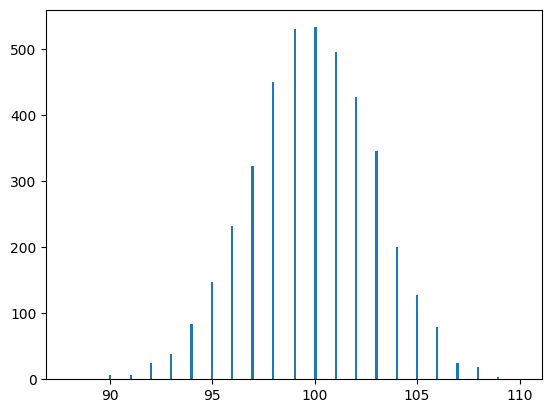

In [31]:
# ZIPF distribution
# sample hit to each selected prefix with the given distribution
hist = []
total_num_requests = 4096
num_patterns = 200
k = 1.2

while len(hist) < total_num_requests:
    tool_uses = np.random.zipf(a=k, size=num_patterns)
    valid_tool_uses = [t for t in tool_uses if t < num_patterns]
    hist.extend(valid_tool_uses[: total_num_requests - len(hist)])

# Normal distribution
import numpy as np
import scipy.stats as ss

x = np.arange(0, num_patterns)
xU, xL = x + 0.5, x - 0.5
prob = ss.norm.cdf(xU, scale=3, loc=num_patterns // 2) - ss.norm.cdf(
    xL, scale=3, loc=num_patterns // 2
)
prob = prob / prob.sum()  # normalize the probabilities so their sum is 1
hist = np.random.choice(x, size=total_num_requests, p=prob)

import matplotlib.pyplot as plt

plt.hist(hist, bins=num_patterns)